<a href="https://colab.research.google.com/github/Alirezamirbagheri/emotor-assembly-inspection-ml/blob/main/emotor-assembly-inspection-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Mounting the Gdrive
from google.colab import drive
from google.colab.patches import cv2_imshow
import sys, os
drive.mount('/content/gdrive', force_remount=True)

# Changing and adjusting the working directory = should be customized
dir_path = '/content/gdrive/My Drive/ML/Image_Classification/EMotor_Inspection'
sys.path.append(dir_path)
os.chdir(dir_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import tensorflow as tf
# from scripts.check import *
!ls "/content/gdrive/My Drive/ML/Image_Classification/EMotor_Inspection/data"

Mounted at /content/gdrive
side  top


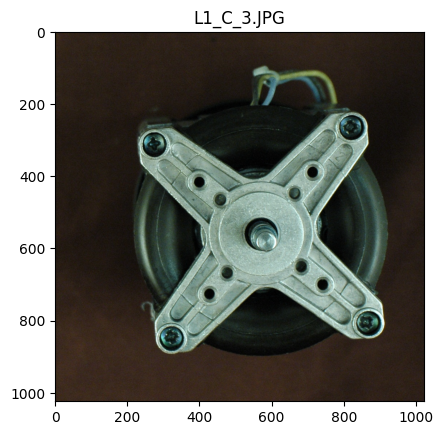

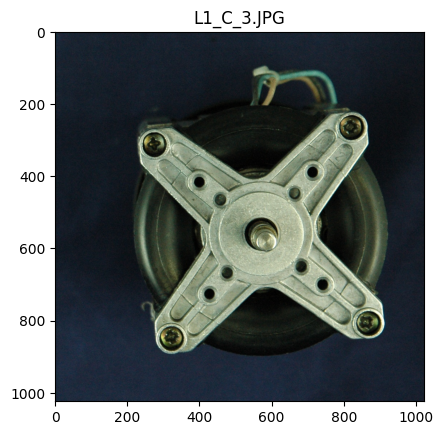

In [8]:
#### Section 1.1: Data preprocessing
# Loading one image in the top view
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape
type(img)

# Now we want to plot the image
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

# By default, open cv assumes the images are encoded in BGR.
# However, the actual order of the color channels is BRG. Thus, the channels need to be converted
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image from bgr to rgb
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

# 1: we need to load all the available images from the given data folder *folder*. Besides the image, we need to also find the class of the respective image.
#The information of the class is encoded in the title of each image. You can use the helper function `get_label_from_name(path)` to parse the filename to the class.

import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error



# Check data import
## quality_gate_111(features, labels)

####2 Image Processing.We haveloaded all images and labels before
#Before analyzing the images using machine learning, they need to be preprocessed. We will do preprocessing regarding three aspects:
#- **Image size**: As the raw images are available in rather high resolution, it might be beneficial to reduce the image resolution. Opencv provides the function `resize()` which works great for that purpose
#- **Image color**: In many use cases, the benefit of considering color information might not outway the increased complexity, thus it might be handy to convert the rgb image to bw. This can easily be done using the `cvtColor` function from opencv.
#- **Image shape**: Only some algorithms are capable of analyzing the 2.5D structure of image data. For the remaining algorithms, which expect the data to be 1D vector, the image data needs to be flattened from 2.5D to 1D. This can be done using the numpy `reshape` functionality.

def image_preprocessing(img, size=(64,32), flatten=True, color=False):
    # Resize
    img = cv2.resize(img, size)

    # Convert to grayscale if requested
    if not color and img.ndim == 3:  # only convert if image has 3 channels
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Flatten if requested
    if flatten:
        img = img.reshape(-1)

    return img

def load_features_labels(folder, size=(8,8), flatten=True, color=False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], []

    # Case-insensitive glob
    files = glob.glob(folder + "/*.JPG") + glob.glob(folder + "/*.jpg")

    for file in files:
        if any(identifier in file for identifier in identifiers):
            # Always load in color first (so preprocessing can handle conversion)
            img = cv2.imread(file, cv2.IMREAD_COLOR)
            if img is None:
                print(f"⚠️ Could not load {file}")
                continue

            # Apply preprocessing
            img_proc = image_preprocessing(img, size=size, flatten=flatten, color=color)

            features.append(img_proc)
            labels.append(get_label_from_name(file))

    return np.array(features), np.array(labels)

features, labels = load_features_labels("./data/top", size=(8, 8), flatten=True, color=False)

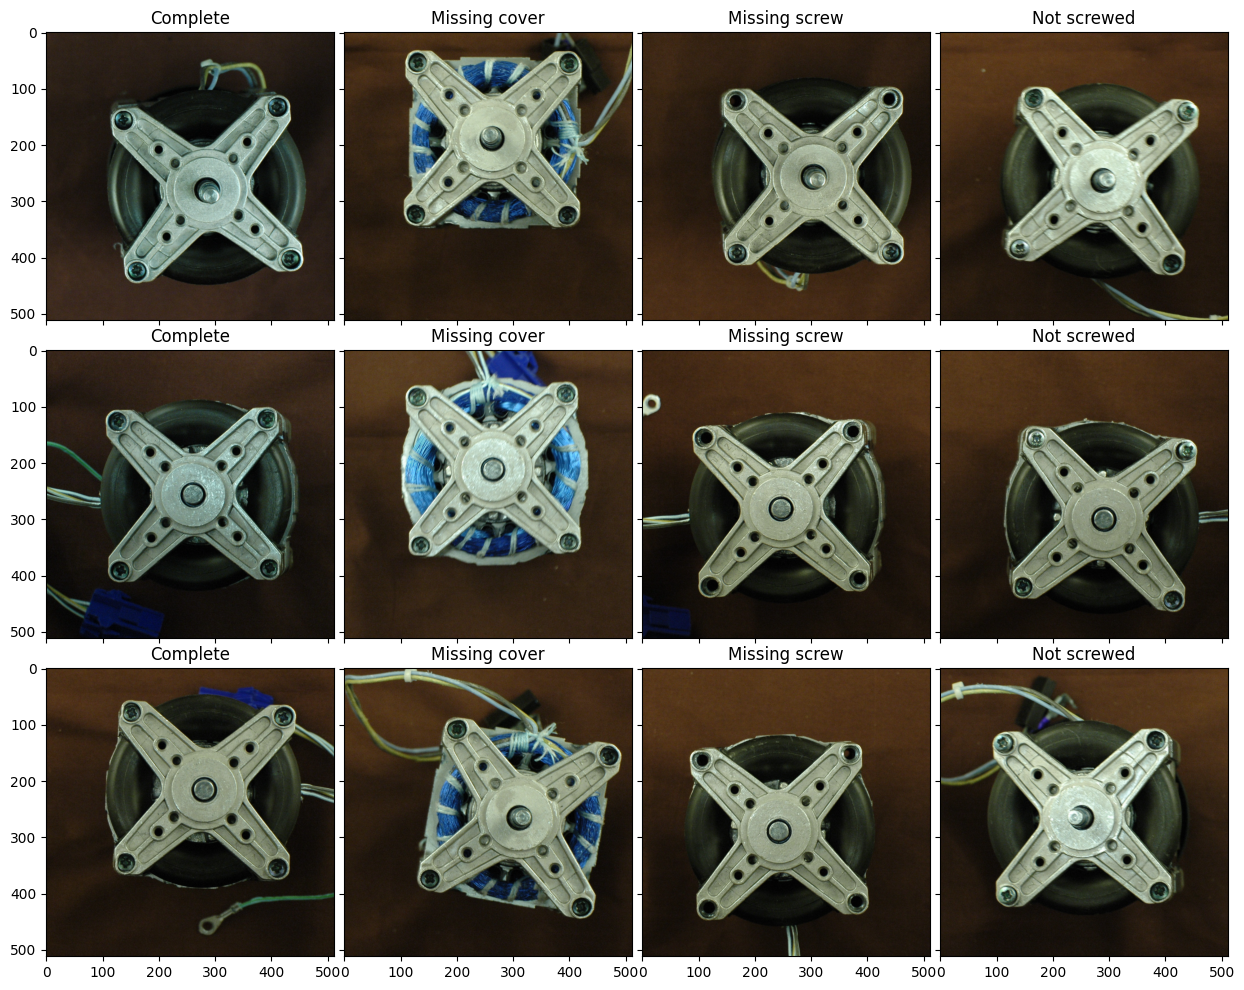

Counter({np.str_('Not screwed'): 47, np.str_('Missing screw'): 42, np.str_('Missing cover'): 22, np.str_('Complete'): 6})


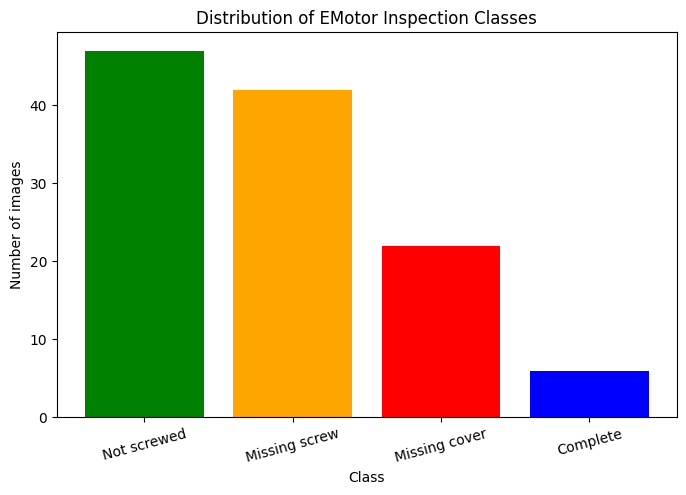

In [9]:
## Section 1.2: First data analysis
# Before diving into machine learning, we'll have a look at the data. With the snippet below you can visualize a sample of the image data available here.
# It can be observed that the class *missing cover* is rather distinct to the remaining classes, as the large black plastic cover is missing, exposing the copper wires. The defect *missing screw* is definitely harder to spot as the screws are rather small objects and the color difference between the screw and the empty hole is rather subtle. Finally, the defect *not screwed* can only be seen as some of the screws are not in the shade of the respective hole, thus indicating they are not screwed in all the way.

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./data/top", size=(512, 512), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    selectedClass = classes[i%4] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    image = images[i//4] # Select image
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

#### First, let's investigate the distribution of the available images among the classes.
from collections import Counter
print(Counter(labels))

# Count the number of images in each class
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(8,5))
plt.bar(classes, counts, color=['green', 'orange', 'red', 'blue'])
plt.title("Distribution of EMotor Inspection Classes")
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.xticks(rotation=15)
plt.show()


Shape feature vector: (70, 192)
Shape label vector: (70,)
Score: 0.6190476190476191
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


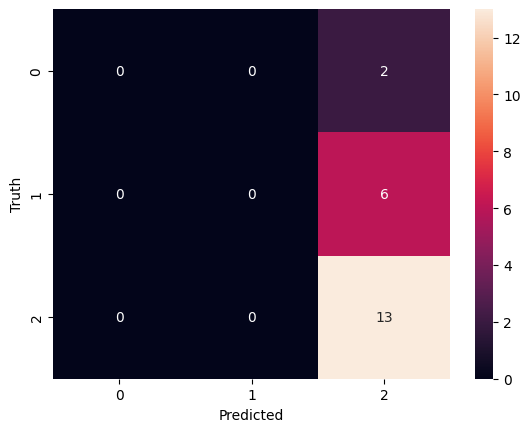

In [10]:

## We should analyze the result and see Which issues and challenges might appear during model training?

## Section 1.3: Image classification using Support Vector Machines
# In this section, we'll use Support Vector Machines (SVM) to try classifying the image dataset. For SVMs, it is necessary to have the data formatted as 1D vector.
# Also, we are only going to consider the three classes *complete*, *missing cover*, and *missing screws*.

features, labels = load_features_labels("./data/top", size=(8,8), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

# As we can see, we still load our 117 images, but the pixel values are now simply reshaped to 1D.
# Next, we need to separate our data into training and testing datasets. This can be achieved using the `train_test_split()` function from sklearn.
## in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also, the datasets should be stratified by the label vector.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,        # feature vectors
    labels,          # corresponding labels
    test_size=0.3,   # 30% for testing
    stratify=labels, # maintain class proportions
    random_state=42  # for reproducibility
)

from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=1) # Initialize the SVM
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
print("Score:", clf.score(X_test, y_test)) # Test the model

# SVC → Support Vector Classifier from scikit-learn. It’s used for classification tasks.
# compute_sample_weight → calculates weights for each training sample to compensate for class imbalance.
# kernel="rbf" → Radial Basis Function kernel, a nonlinear kernel.
# gamma=0.01 → controls the influence of a single training example. Lower → more influence.
# C=0.0003 → regularization parameter. Lower C → more regularization (simpler model).
# These hyperparameters are very small. With 16×16 flattened images, we might need to tune them to get good accuracy.
# compute_sample_weight('balanced', y_train) → gives higher weight to samples from minority classes so the classifier does not ignore them.
# clf.fit(...) → trains the SVM on the weighted training data.
# clf.score(X_test, y_test) → computes the accuracy on the test set

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

# Accuracy on test set = 62% → model correctly predicted 13 of 21 images.
# Support → number of images in test set for each class.
# Precision = correct predictions / total predicted as that class
# Recall = correct predictions / total true samples of that class

# Problems
# Class imbalance:
# Train labels likely dominated by "Missing screw"
# Even with sample_weight='balanced', SVM may still focus on majority class.
# Small dataset (70 training images):
# 3 classes → ~23 samples per class on average → too few for SVM to learn properly.
# Feature size (3072) is large for small dataset → model may overfit or underfit.
# Hyperparameters:
# C=0.0003, gamma=0.01. Even with c=1 nothing changed. with also 8*8 nothing.
# Very small C → SVM underfits → may predict only the largest class.
# Larger C → less regularization → better fitting
# Gamma → controls smoothness of decision boundary
# we need Data augmentation (rotate, flip, shift images) → increase training size
# or Use other classifiers: Random Forest, Logistic Regression, or even a small CNN if dataset grows.


Shape feature vector: (70, 49152)
Shape label vector: (70,)
Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │     1,572,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,475 (6.00 MB)

 Trainable params: 1,573,475 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3022 - loss: 313.0601 - val_accuracy: 0.6000 - val_loss: 384.9921
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5130 - loss: 414.5437 - val_accuracy: 0.5000 - val_loss: 112.1852
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6425 - loss: 95.6026 - val_accuracy: 0.6000 - val_loss: 237.6043
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6254 - loss: 62.0856 - val_accuracy: 0.4000 - val_loss: 83.0036
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8120 - loss: 32.7399 - val_accuracy: 0.6000 - val_loss: 122.6185
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8413 - loss: 23.4311 - val_accuracy: 0.8000 - val_loss: 20.1358
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9328 - loss: 9.2064 - val_accuracy: 0.5000 - val_loss: 154.5287
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8204 - loss: 10.7081 - val_accuracy: 

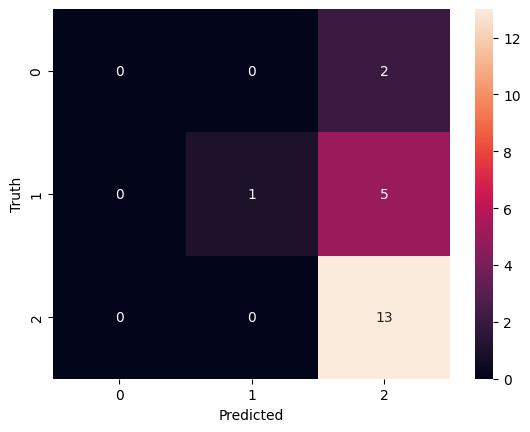

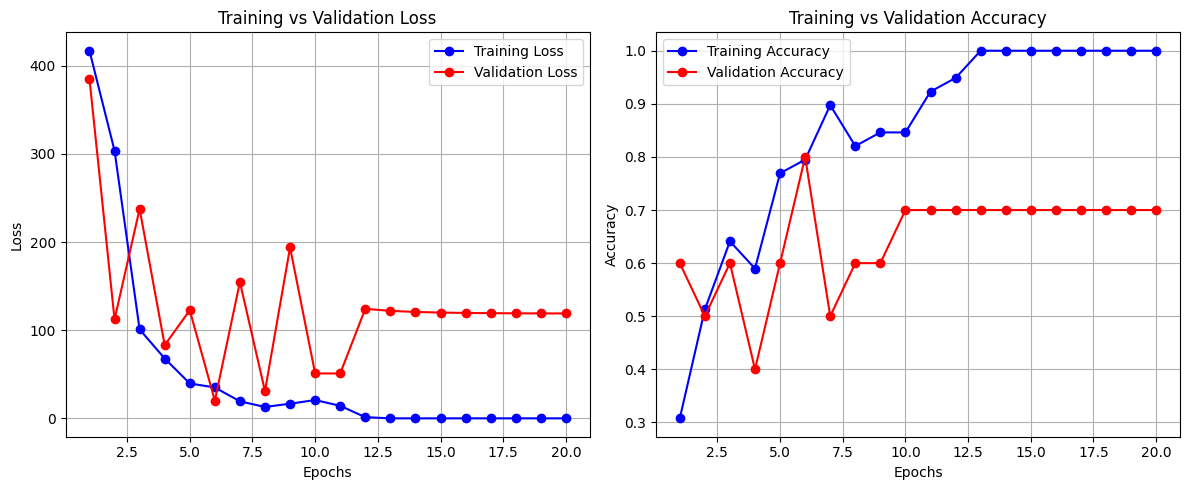

In [11]:
##### Section 1.4: Image classification with artificial neural networks
# In this section, we will train our first artificial neural network (ANN) for image classification.
# First, we will have a look at normal ANNs. These consist of multiple dense layers which can analyze one-dimensional feature vectors.
# Thus, we need to reshape our 2.5-dimensional image data to 1D using the `flatten` option we integrated into our preprocessing function.

### a) Image classification using fully connected ANNs
# Again, we need to load the data using the `flatten=True` flag to convert the 2.5D data to 1D.

features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,        # feature vectors
    labels,          # corresponding labels
    test_size=0.3,   # 30% for testing, 70% for training
    stratify=labels, # maintain class proportions
    random_state=42  # for reproducibility
)

# The labels need to be *one hot encoded*. In one hot encoding, categorical values are transformed into a binary representation.
# The sklearn preprocessing library contains a variety of useful data preprocessing tools such as one hot encoding
from sklearn.preprocessing import OneHotEncoder
# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])
# Create the encoder object
enc = OneHotEncoder(sparse_output=False) # Generate Encoder
# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1))
# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

# Now, let's define a simple ANN with an input layer, 3 hidden layer and one output layer.
# Here we use the **keras** library to model the neural network.
# A simple ANN with multiple sequential layers can be created using the `Sequential()` model.
# Afterwards, various layers can be added to the model through the command `model.add(LAYER)` with *LAYER* defining the layer to be added.
# In the first layer, the shape of the input needs to be specified using the parameter `input_shape`. This is only necessary in the first, but not in consecutive layers.

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

model = Sequential()
model.add(Dense(32, input_shape = X_train[0].shape))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(y_train[0].shape[0]))
model.add(Activation("softmax"))

print(model.summary())

# Param # (Parameters)
# Dense layer → parameters = (input_features × neurons) + neurons (bias).
# First dense layer:
# input features = 128*128*3 = 49152
# neurons = 32
# params = 49152*32 + 32 = 1,572,896
# Second dense layer:
# input features = 32
# neurons = 16
# params = 32*16 + 16 = 528
# Output layer:
# input features = 16
# neurons = 3
# params = 16*3 + 3 = 51
# Activation layers have 0 parameters because they just apply a function to the output.

#### Next, the model needs to be compiled using a `loss` function and an `optimizer`.
# The loss function defines how the loss is computed during model training, while the optimizer defines how the weights need to be adjusted during backpropagation

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
# Now, the model can be trained using the datasets defined before.
# Adam = adaptive learning rate optimization algorithm.
# Combines the benefits of Momentum and RMSProp.
# Good default choice for most problems.
# Accuracy → fraction of correctly classified samples. Keras will report accuracy during training and evaluation.

history = model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)
# or just model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1) without history to save data
# model.fit(...) trains your neural network on the training data
# epochs=20 → the model will go through the dataset 20 times
# batch_size=8 → training is done in mini-batches of 8 samples, not the whole dataset at once
# validation_split=0.2 → 20% of training data is set aside for validation, so the model doesn’t train on it
# verbose=1 → prints a progress bar and metrics during training
# For each batch:
# Forward pass → compute predicted outputs
# Compute loss → compare predicted vs true labels
# Backward pass → update weights using optimizer
# After all batches → compute average training loss & accuracy
# Compute validation loss & accuracy on the 20% validation split
# Epoch = one complete pass through your entire training dataset.
# If you set epochs=1, the model sees each training sample only once.
# With 70 training samples, one epoch is usually not enough for the model to learn meaningful patterns.
# Each epoch allows the network to refine its weights further.
# Batch size = number of samples the network processes before updating its weights.
# After each batch, weights are updated based on the loss of that batch

# You can use the following function to evaluate your model.
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

evaluate_model(X_test, y_test, model)

# After training, you can access the historyy to plot learning curves
# print(history.history.keys())  # 'loss', 'accuracy', 'val_loss', 'val_accuracy'

# Extract data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)
Label of first sample after OneHot encoding: [0. 1. 0.]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,571 (29.57 KB)

 Trainable params: 7,571 (29.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4138 - loss: 8.2191 - val_accuracy: 0.2000 - val_loss: 4.4129
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1629 - loss: 4.6511 - val_accuracy: 0.2000 - val_loss: 2.3267
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2756 - loss: 4.4395 - val_accuracy: 0.4000 - val_loss: 1.9884
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4280 - loss: 1.5465 - val_accuracy: 0.4000 - val_loss: 2.9294
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5152 - loss: 2.0538 - val_accuracy: 0.4000 - val_loss: 2.3262
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4943 - loss: 1.4203 - val_accuracy: 0.6000 - val_loss: 1.1539
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4848 - loss: 0.8987 - val_accuracy: 0.8000 - val_loss: 0.7779
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4337 - loss: 0.7631 - val_accuracy: 0.8000 - val_loss: 0.6844
Epoch 

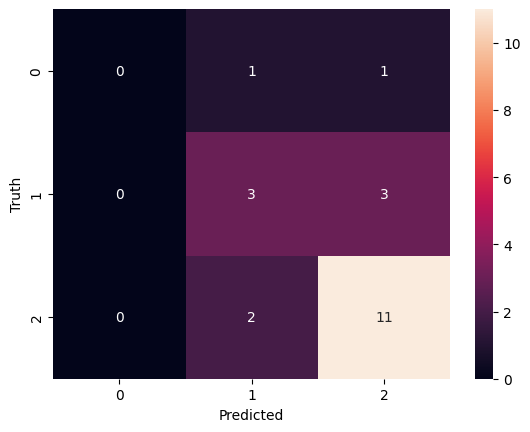

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.4605 - loss: 8.5504 - val_accuracy: 0.6000 - val_loss: 0.5337
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.3182 - loss: 12.7797 - val_accuracy: 0.2000 - val_loss: 1.5156
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.4812 - loss: 2.1743 - val_accuracy: 0.2000 - val_loss: 1.2139
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.3081 - loss: 1.4164 - val_accuracy: 0.2000 - val_loss: 1.0091
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.3770 - loss: 1.9914 - val_accuracy: 0.6000 - val_loss: 1.0392
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5904 - loss: 1.3221 - val_accuracy: 0.4000 - val_loss: 0.8247
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.5891 - loss: 0.5723 - val_accuracy: 0.2000 - val_loss: 0.6854
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.6984 - loss: 0.3789 - val_accuracy: 0.4000 - va

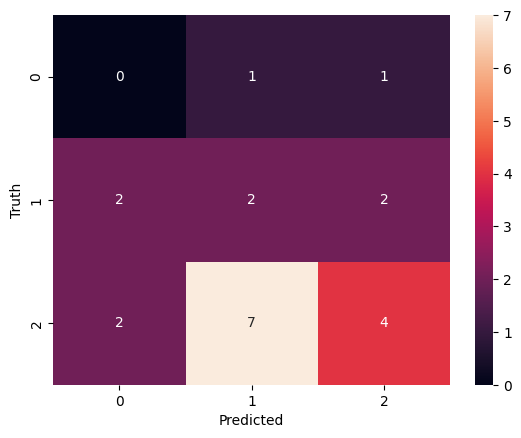

In [12]:
##### Section 1.4: ### b) Image classification using CNNs
# In this section, we are going to explore the usage of CNNs for the given task.
# First, the data is loaded from file. As CNNs are capable and even excel on analyzing the multiple dimensional aspects of images,
# the images do not need to be reshaped in a one-dimensional vector. Thus, we have to set the flag `flatten` to `False`.
# we can see, that the shape of the loaded images is now a four-dimensional array with `(number of samples, width image, height image, color channels image)`.

features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

def split_data(features, labels):
    # Split with 70/30 and stratify to preserve class distribution
    return train_test_split(
        features, labels,
        test_size=0.3,
        stratify=labels,
        random_state=42
    )

def encode_labels(y_train, y_test):
    # Create OneHotEncoder (newer sklearn uses sparse_output=False)
    enc = OneHotEncoder(sparse_output=False)

    # Fit on training labels and transform
    y_train = enc.fit_transform(y_train.reshape(-1, 1))
    # Transform test labels with same encoder
    y_test = enc.transform(y_test.reshape(-1, 1))

    return y_train, y_test

X_train, X_test, y_train, y_test = split_data(features, labels)
y_train, y_test = encode_labels(y_train, y_test)

print("Label of first sample after OneHot encoding:", y_train[0])

######################################################################################################
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

# The number of filters (like 8, 16, 32, etc.) in a convolutional layer is a design choice — there’s no fixed rule like “must be 8.”
# Filters = feature detectors
# Each filter learns to detect a different pattern (edges, textures, shapes, etc.). # More filters → the network can learn more complex features.
# But more filters also → more parameters → more memory + risk of overfitting.
# Early layers usually start small (e.g., 8 or 16 filters) because they’re learning basic edges and textures, which don’t need many filters.
# Later layers (like your 16 and 32) expand the filter count because higher-level features (like shapes or object parts) are more complex.
# A common heuristic is to double the filters as you go deeper: 8 → 16 → 32 → 64 … This matches the idea that deeper layers need richer feature maps.

# the activation function is applied inside the layer right after the convolution, not as a separate step. Alternatively, you could separate them if you want more control.
# Both versions do the same thing — the first one is just more compact.

# In Keras, the default for MaxPooling2D() is: MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"). So, even though you didn’t write (2,2), it’s automatically assumed.

# Why use Global Max Pooling?
# 1. Translation invariance: Doesn’t matter where in the image the feature appears. As long as it appears strongly somewhere, the pooled value keeps it.
# 2. Keeps the strongest feature. Each convolution filter is trained to detect something (e.g., an edge, a screw head, a missing cover).
# Global MaxPooling picks the strongest activation per filter → "Did this filter detect its feature anywhere in the image?".
# 3. Drastically reduces parameters. Flattening (turning the whole 2D map into a vector) creates a huge input for the Dense layer.
# Global pooling gives just one number per channel → much smaller vector.
# Example:
# Flatten (16×16×32) → 8,192 values.
# GlobalMaxPooling2D → 32 values. → This reduces overfitting and training time.

# Why image size doesn’t matter. Each filter "slides" across the whole image, reusing the same weights everywhere. So the number of parameters only depends on:
# filter size (3×3, 5×5, etc.)
# input depth (e.g., 3 for RGB)
# number of filters
# The input image size only changes the output feature map dimensions (e.g., 512×512 vs 256×256), but the filters don’t need extra weights—they just get applied more times.
# First Conv2D layer: Conv2D(8, 5, input_shape=(512, 512, 3))
# Kernel size = 5×5, Input channels = 3 (RGB), Output filters = 8, (5×5×3×8)+8=600+8=608

from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

history = model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Evaluate the trained CNN
evaluate_model(X_test, y_test, model)

# Extract data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Performance Optimization of the Model
# With the above starter code, a first improvement in accuracy compared to the SVM and the ANN using only Dense layers is visible.
# However, the network could be further improved by adjusting the hyperparameters. Below there is the full snippet from data preprocessing to model training.
# We can Play around with the parameters and see whether we can find a model that shows an even better performance!
# >Some ideas are:
# >- Explore different sized images (smaller/larger)
# >- How do black and white images compare to the rgb ones?
# >- Adapt the architecture of the neural network:
# > - Change the amount of Conv2D layers
# > - Change the number of filters in each layer
# > - Explore other activation functions
# >- Change the learning rate of the optimizer or look at different optimizers all together
# >- Train the model for more epochs
# > >**For comparability, we should not change the ratios for train/test and train/validation!**

np.random.seed(28)
# Many machine learning operations (like weight initialization, shuffling, data splitting, augmentations) involve randomness.
# Without fixing the seed, you may get slightly different results each time you run your code.
# By setting a seed (like 28), NumPy’s random number generator will always start from the same state, so you’ll get the same sequence of “random” numbers

####################################################
# I modified the following lines                #
# ! Don't change training/test/validation ratios ! #
####################################################

# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels

# Model definition
model = Sequential()
model.add(Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
history = model.fit(np.array(X_train), np.array(y_train), epochs = 50, batch_size = 2, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model)

# Extract data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



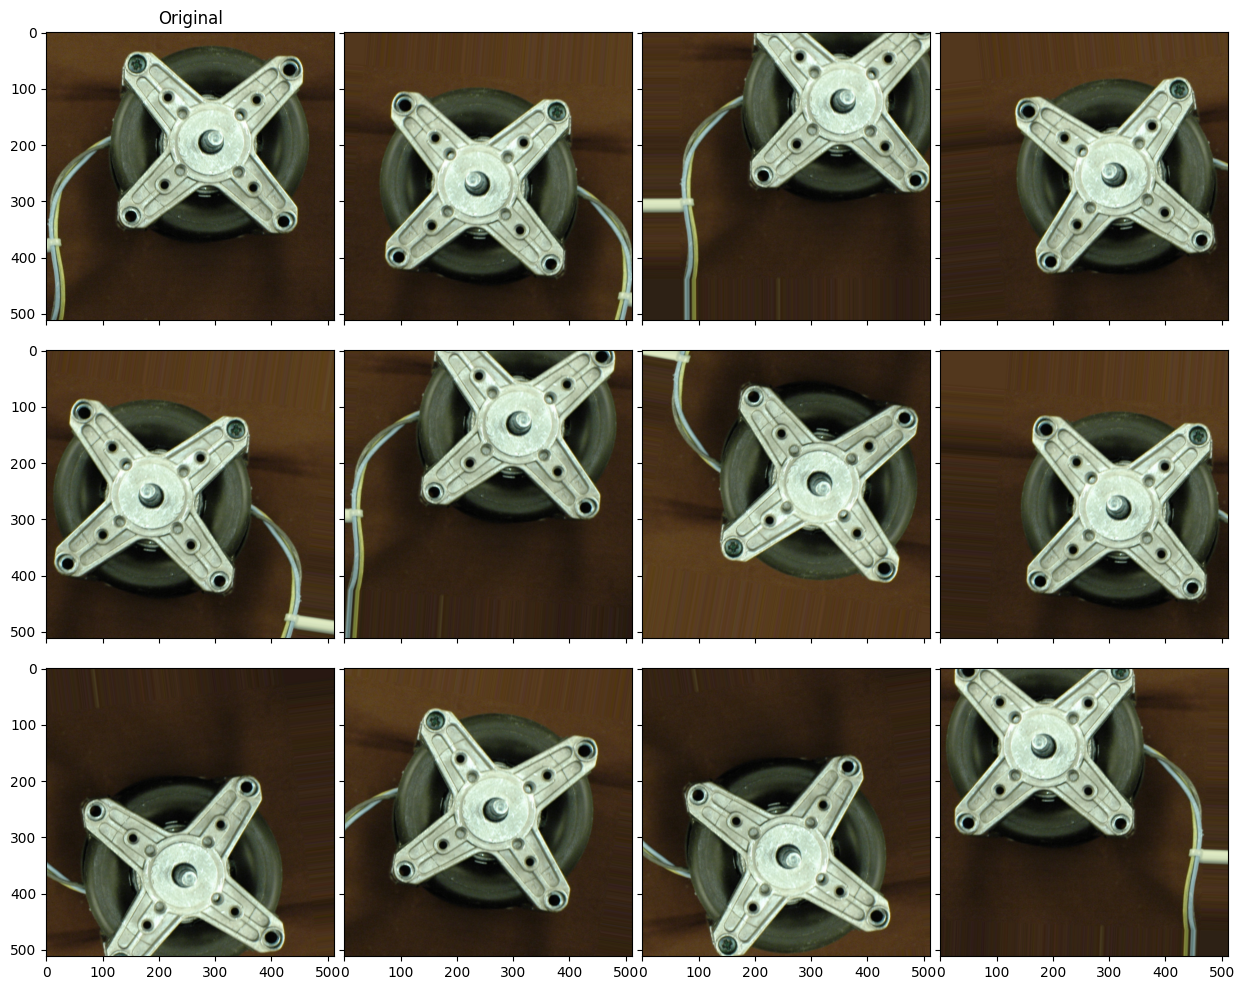

In [13]:
## Section 1.5: Data augmentation

# Data augmentation is a technique for artificially increasing the dataset without the need for additional data acquisition. The reason for this is, that most machine learning models perform better the higher the available data volume is.
# Data augmentation uses the principle of slight modifications to the original data to create new data, while using the labels of the existing image. As those modifications are rather small, the image as a whole is not changed by a lot and the to be identified object, or in our case image class, can still be recognized. However, the training process can be increased significantly. One can think of many variations of these slight modifications of an image. Typical examples include:
# - Random flipping of the image horizontally or vertically
# - Random rotations
# - Random shifts
# - Blurring the image
# - Adding artificially created noise
# - Cropping
# - Changes in contrast
# - Elastic deformations

### Implementation in keras
# **Keras** includes its own procedure for image augmentation using the `ImageDataGenerator` generator.
# This generator offers a variety of data augmentation strategies, that are directly applied to the raw data during model training.
# Thus, the augmented data does not need to be stored to the disk.

# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# rotation_range=10 does not mean “10% of images”. It means:
# Each image that passes through the generator will be rotated randomly by an angle between -10° and +10°.
# This is applied every time the generator yields a batch.
# rotation_range=10 → random rotations up to ±10°.
# width_shift_range=0.2 → shift horizontally up to 20% of image width.
# height_shift_range=0.2 → shift vertically up to 20%.
# horizontal_flip=True → randomly mirror images left/right.
# vertical_flip=True → randomly mirror images up/down.
# All the transformations in ImageDataGenerator (rotation, width/height shift, flips, zoom, etc.) are applied probabilistically and independently on each image every time it is generated.
# For one image passing through the generator: # It can be rotated, # shifted horizontally and vertically, flipped horizontally and/or vertically, all at the same time.

# When you apply a shift with ImageDataGenerator, the "newly created pixels" (the empty space that appears after shifting) have to be filled somehow.
# By default, Keras uses: fill_mode="nearest" That means: If an image is shifted right, the empty pixels on the left will be filled with the value of the nearest edge pixel (replicating the border).
# Similarly, if shifted down, the empty space on top is filled with the closest row of pixels. You can control this with the fill_mode parameter:
# "nearest" → (default) repeats nearest pixel values.
# "constant" → fills with a constant value (default = 0 → black).
# "reflect" → mirrors the image content at the border.
# "wrap" → wraps around from the other side of the image.

random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3)) # Creates a 3 × 4 grid → 12 slots for images.
grid[0].imshow(features[random_index])                              # First slot (index 0) shows the original image.
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):                                   # For each of the remaining 11 slots, the code asks the generator to create one new augmented image.
    image = next(datagen.flow(features[[random_index]], batch_size=1))[0].astype(int) #  That means the generator is called 11 times, each time applying a different random combination of transformations.
    ax.imshow(image) # Plot image
plt.show()


In [15]:
### Run model training with given data generator
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)
# stratify=y_train ensures class balance is preserved.

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))
# This does not add permanent images to your dataset. Instead, it generates randomly transformed versions of each batch on the fly.
# Meaning: each epoch, the network sees different variations of the same training images.

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=len(X_train) / 8, epochs=50)
# steps_per_epoch = len(X_train)/8 → ensures all training samples are used once per epoch.
# Since you’re using datagen.flow(...), each epoch trains on augmented versions of your training data.
# Validation data (X_validation, y_validation) is used without augmentation (as it should).


# Extract data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


TypeError: 'float' object cannot be interpreted as an integer